In [2]:
#pip install holidays-es

In [3]:
#pip install mlflow

In [2]:
from sklearn import preprocessing
import pandas as pd
import numpy as np
from math import pi, sin, cos
from datetime import datetime
from holidays_es import get_provinces, Province
import sys
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
import mlflow
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn import set_config; set_config(display='diagram')
import pickle
from typing import Dict, List, Tuple, Sequence

In [3]:
from google.cloud import storage

BUCKET_NAME = "bicimad_data"

storage_filename = "alldata.csv"
local_filename = "alldata.csv"

client = storage.Client()
bucket = client.bucket(BUCKET_NAME)
blob = bucket.blob(storage_filename)
blob.download_to_filename(f'../raw_data/{local_filename}')

In [4]:
df = pd.read_csv('../raw_data/alldata.csv')

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (6,7,10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5373414 entries, 0 to 5373413
Data columns (total 28 columns):
 #   Column              Dtype  
---  ------              -----  
 0   activate            int64  
 1   name                object 
 2   reservations_count  int64  
 3   light               int64  
 4   total_bases         int64  
 5   free_bases          int64  
 6   number              object 
 7   longitude           object 
 8   no_available        int64  
 9   address             object 
 10  latitude            object 
 11  dock_bikes          int64  
 12  id                  object 
 13  time                int64  
 14  date                object 
 15  holidays            bool   
 16  datetime            object 
 17  feels_like          float64
 18  weather_main        object 
 19  weekday             int64  
 20  year                int64  
 21  month               int64  
 22  hour_sin            float64
 23  hour_cos            float64
 24  weekday_sin         floa

## 1) Cleaning data

In [6]:
df.shape

(5373414, 28)

In [7]:
# removing redundant columns or rows
df = df.drop(columns=['activate', 'name', 'light', 'total_bases', 'free_bases', 
                      'longitude', 'no_available', 'address', 'latitude', 'id', 'date'])
df = df.drop_duplicates()
df.shape

(5365214, 17)

In [8]:
# handling the warnings with the column 6 that have mixed types
df.number = df.number.astype(str)

In [9]:
df = df.dropna(how='any', axis=0)
df.shape

(5365214, 17)

In [10]:
def compress(df, **kwargs):
    """
    Reduces size of dataframe by downcasting numerical columns
    """
    input_size = df.memory_usage(index=True).sum()/ 1024**2
    print("old dataframe size: ", round(input_size,2), 'MB')
    
    in_size = df.memory_usage(index=True).sum()
    for t in ["float", "integer"]:
        l_cols = list(df.select_dtypes(include=t))
        for col in l_cols:
            df[col] = pd.to_numeric(df[col], downcast=t)
    out_size = df.memory_usage(index=True).sum()
    ratio = (1 - round(out_size / in_size, 2)) * 100
    
    print("optimized size by {} %".format(round(ratio,2)))
    print("new dataframe size: ", round(out_size / 1024**2,2), " MB")
    return df

In [11]:
df = compress(df, verbose=True)
df.head(1)

old dataframe size:  700.98 MB
optimized size by 50.0 %
new dataframe size:  347.93  MB


,reservations_count,number,dock_bikes,time,holidays,datetime,feels_like,weather_main,weekday,year,month,hour_sin,hour_cos,weekday_sin,weekday_cos,month_sin,month_cos
0,0,1a,3,0,False,2021-06-010,17.440001,Rain,1,2021,6,0.0,1.0,0.781832,0.62349,0.5,0.866025


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5365214 entries, 0 to 5373413
Data columns (total 17 columns):
 #   Column              Dtype  
---  ------              -----  
 0   reservations_count  int8   
 1   number              object 
 2   dock_bikes          int8   
 3   time                int8   
 4   holidays            bool   
 5   datetime            object 
 6   feels_like          float32
 7   weather_main        object 
 8   weekday             int8   
 9   year                int16  
 10  month               int8   
 11  hour_sin            float32
 12  hour_cos            float32
 13  weekday_sin         float32
 14  weekday_cos         float32
 15  month_sin           float32
 16  month_cos           float32
dtypes: bool(1), float32(7), int16(1), int8(5), object(3)
memory usage: 347.9+ MB


## 2) Visualizing data

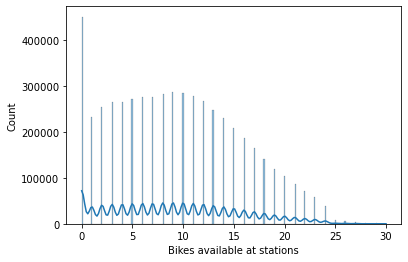

In [13]:
sns.histplot(df['dock_bikes'], kde=True)
plt.xlabel('Bikes available at stations')
plt.show()

<AxesSubplot:xlabel='weekday', ylabel='dock_bikes'>

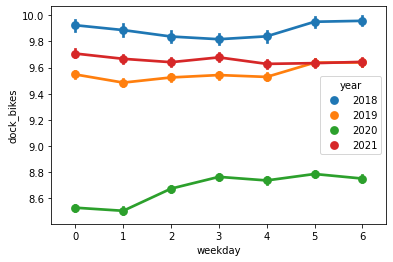

In [14]:
sns.pointplot(x='weekday',y='dock_bikes',hue='year',join=True,data=df)

<AxesSubplot:xlabel='month', ylabel='dock_bikes'>

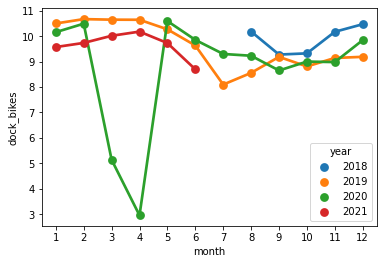

In [15]:
sns.pointplot(x='month',y='dock_bikes',hue='year',join=True,data=df)

<AxesSubplot:xlabel='weather_main', ylabel='dock_bikes'>

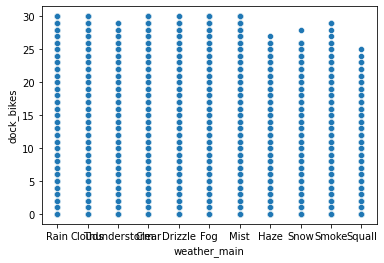

In [16]:
sns.scatterplot(x='weather_main',y='dock_bikes',data=df)

##  3) Preprocessing

In [16]:
# copying the dataset for editing without affecting the original
temp = df.copy()

In [17]:
temp['datetime'] = temp['datetime'].apply(lambda x: x[0:10]+' '+x[10:]+':00')

In [18]:
temp['datetime']=pd.to_datetime(temp['datetime'], format='%Y-%m-%d %H:%M:%S')

In [19]:
temp = temp.set_index('datetime')

In [20]:
temp.sort_values(by='datetime')

,reservations_count,number,dock_bikes,time,holidays,feels_like,weather_main,weekday,year,month,hour_sin,hour_cos,weekday_sin,weekday_cos,month_sin,month_cos
datetime,,,,,,,,,,,,,,,,
2018-08-01 00:00:00,0,108,14,0,False,23.190001,Clear,2,2018,8,0.000000,1.000000,0.974928,-0.222521,1.0,6.123234e-17
2018-08-01 00:00:00,0,138,0,0,False,23.190001,Clear,2,2018,8,0.000000,1.000000,0.974928,-0.222521,1.0,6.123234e-17
2018-08-01 00:00:00,0,97,17,0,False,23.190001,Clear,2,2018,8,0.000000,1.000000,0.974928,-0.222521,1.0,6.123234e-17
2018-08-01 00:00:00,0,33,0,0,False,23.190001,Clear,2,2018,8,0.000000,1.000000,0.974928,-0.222521,1.0,6.123234e-17
2018-08-01 00:00:00,0,137,9,0,False,23.190001,Clear,2,2018,8,0.000000,1.000000,0.974928,-0.222521,1.0,6.123234e-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-30 23:00:00,0,19,9,23,False,24.129999,Clear,2,2021,6,-0.258819,0.965926,0.974928,-0.222521,0.5,8.660254e-01
2021-06-30 23:00:00,0,197,1,23,False,24.129999,Clear,2,2021,6,-0.258819,0.965926,0.974928,-0.222521,0.5,8.660254e-01
2021-06-30 23:00:00,1,196,11,23,False,24.129999,Clear,2,2021,6,-0.258819,0.965926,0.974928,-0.222521,0.5,8.660254e-01


### 3.1) Scaling and Encoding :

In [21]:
temp.year = temp.year.astype(str)

In [22]:
temp.dtypes

reservations_count       int8
number                 object
dock_bikes               int8
time                     int8
holidays                 bool
feels_like            float32
weather_main           object
weekday                  int8
year                   object
month                    int8
hour_sin              float32
hour_cos              float32
weekday_sin           float32
weekday_cos           float32
month_sin             float32
month_cos             float32
dtype: object

In [23]:
num_col = temp.select_dtypes(['int8','float32']).drop(columns='dock_bikes')

In [24]:
cat_col = temp.select_dtypes(['object','bool'])

In [40]:
cat_col

,number,holidays,weather_main,year
datetime,,,,
2021-06-01 00:00:00,1a,False,Rain,2021
2021-06-01 01:00:00,1a,False,Clouds,2021
2021-06-01 02:00:00,1a,False,Thunderstorm,2021
2021-06-01 02:00:00,1a,False,Rain,2021
2021-06-01 03:00:00,1a,False,Rain,2021
...,...,...,...,...
2021-05-31 20:00:00,9,False,Rain,2021
2021-05-31 21:00:00,9,False,Thunderstorm,2021
2021-05-31 21:00:00,9,False,Rain,2021


In [25]:
num_transformer = StandardScaler()
cat_transformer = OneHotEncoder(sparse=False, handle_unknown='ignore')

In [26]:
preproc = make_column_transformer(
    (num_transformer, num_col.columns),
    (cat_transformer, cat_col.columns),
    remainder='passthrough')

In [27]:
pipe = make_pipeline(preproc)

In [28]:
temp_2021 = temp[temp['year'] == '2021'].copy()

In [29]:
# Training in a part of the model that has all the stations
pipe.fit(temp_2021)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  Index(['reservations_count', 'time', 'feels_like', 'weekday', 'month',
       'hour_sin', 'hour_cos', 'weekday_sin', 'weekday_cos', 'month_sin',
       'month_cos'],
      dtype='object')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  Index(['number', 'holidays', 'weather_main', 'year'], dtype='object'))]))])

In [30]:
# Exporting Pipeline as pickle file
#with open("pipe.pkl", "wb") as file:
    #pickle.dump(pipe, file)

In [31]:
columns = list(preproc.named_transformers_['standardscaler'].get_feature_names_out()) + list(preproc.named_transformers_['onehotencoder'].get_feature_names_out()) + ['dock_bikes']

In [32]:
chunk1 = pipe.transform(temp.iloc[0:3_000_000])

In [33]:
chunk2= pipe.transform(temp.iloc[3_000_000:(len(temp)+1)])

In [34]:
temp_model = np.concatenate((chunk1, chunk2))

In [35]:
temp.shape

(5365214, 16)

In [36]:
chunk = 500_000

first = pipe.transform(temp.iloc[0:(chunk)])
for i in range(chunk, (len(temp)+1), chunk):
    if (i+chunk)<=(len(temp)+1):
        temp_proc = pipe.transform(temp.iloc[i:(i+chunk)])
    else:
        temp_proc = pipe.transform(temp.iloc[i:(len(temp)+1)])
    temp_model = np.concatenate((first, temp_proc))

In [37]:
temp_model = pd.DataFrame(temp_model, columns=columns, index= temp.index)

In [38]:
temp_model = compress(temp_model, verbose=True)

old dataframe size:  11829.73 MB
optimized size by 50.0 %
new dataframe size:  5935.33  MB


In [39]:
temp_model.dtypes.unique()

array([dtype('float32')], dtype=object)

In [40]:
some_list = ['2021-05-31 23:00:00']
temp_model[temp_model.index.isin(some_list)]

,reservations_count,time,feels_like,weekday,month,hour_sin,hour_cos,weekday_sin,weekday_cos,month_sin,...,weather_main_Clouds,weather_main_Drizzle,weather_main_Fog,weather_main_Haze,weather_main_Mist,weather_main_Rain,weather_main_Snow,weather_main_Thunderstorm,year_2021,dock_bikes
datetime,,,,,,,,,,,,,,,,,,,,,
2021-05-31 23:00:00,-0.230483,1.656331,0.780904,-1.501293,0.88969,-0.366077,1.361562,0.005253,1.416714,0.85595,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0
2021-05-31 23:00:00,-0.230483,1.656331,0.780904,-1.501293,0.88969,-0.366077,1.361562,0.005253,1.416714,0.85595,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,14.0
2021-05-31 23:00:00,-0.230483,1.656331,0.780904,-1.501293,0.88969,-0.366077,1.361562,0.005253,1.416714,0.85595,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2021-05-31 23:00:00,-0.230483,1.656331,0.780904,-1.501293,0.88969,-0.366077,1.361562,0.005253,1.416714,0.85595,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0
2021-05-31 23:00:00,-0.230483,1.656331,0.780904,-1.501293,0.88969,-0.366077,1.361562,0.005253,1.416714,0.85595,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-31 23:00:00,-0.230483,1.656331,0.780904,-1.501293,0.88969,-0.366077,1.361562,0.005253,1.416714,0.85595,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,11.0
2021-05-31 23:00:00,-0.230483,1.656331,0.780904,-1.501293,0.88969,-0.366077,1.361562,0.005253,1.416714,0.85595,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2021-05-31 23:00:00,-0.230483,1.656331,0.780904,-1.501293,0.88969,-0.366077,1.361562,0.005253,1.416714,0.85595,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


### Creating Sequences

In [41]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [42]:
train_size = int(len(temp_model) * 0.8)
test_size = len(temp_model) - train_size
train, test = temp_model.iloc[0:train_size], temp_model.iloc[train_size:len(temp_model)]
print(len(train), len(test))

4292171 1073043


In [43]:
train.shape

(4292171, 288)

In [45]:
# time_steps = 266

# # reshape to [samples, time_steps, n_features]

# X_train1, y_train1 = create_dataset(train.iloc[:1000000,:], train.iloc[:1000000,:].dock_bikes, time_steps)
# X_test, y_test = create_dataset(test.iloc[:1000000,:], test.iloc[:1000000,:].dock_bikes, time_steps)

# #X_train2, y_train2= create_dataset(train.iloc[2000000:(len(temp_model)+1),:], train.iloc[3000000:(len(temp_model)+1),:].dock_bikes, time_steps)


# print(X_train.shape, y_train.shape)

In [46]:
# X_train = np.concatenate((X_train1,X_train2))

In [47]:
# X = temp_model.drop(columns='dock_bikes')
# y= temp_model.dock_bikes
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

# TRYING another approach using FOLDS

In [43]:
# Let's consider FOLDS with a length of 3 years       #
# (2 years will be used for train, 1 for test!)       #
# --------------------------------------------------- #

FOLD_LENGTH = 24*365 * 3 # every hour = 24h
                        # three years

# --------------------------------------------------- #
# Let's consider FOLDS starting every year       #
# --------------------------------------------------- #
    
FOLD_STRIDE = 24*365 # every year

# --------------------------------------------------- #
# Let's consider a train-test-split ratio of 2/3      #
# --------------------------------------------------- #

TRAIN_TEST_RATIO = 0.66

In [44]:
def get_folds(
    df: pd.DataFrame, 
    fold_length: int,
    fold_stride: int) -> List[pd.DataFrame]:
    '''
    This function slides through the Time Series dataframe of shape (n_timesteps, n_features) to create folds
    - of equal `fold_length`
    - using `fold_stride` between each fold
    
    Returns a list of folds, each as a DataFrame
    '''
    # $CHALLENGIFY_BEGIN
    folds = []
    for idx in range(0, len(df), fold_stride):
        # Exits the loop as soon as the last fold index would exceed the last index
        if (idx + fold_length) > len(df):
            break
        fold = df.iloc[idx:idx + fold_length, :]
        folds.append(fold)
    return folds

In [45]:
folds = get_folds(temp_model, FOLD_LENGTH, FOLD_STRIDE)

In [46]:
print(f'The function generated {len(folds)} folds.')
print(f'Each fold has a shape equal to {folds[0].shape}.')

The function generated 610 folds.
Each fold has a shape equal to (26280, 288).


In [47]:
# starting by one
fold = folds[0]

 -> Now, we want to split this fold **chronologically** into:

- a <font color=blue>train</font> dataframe
- a <font color="#ff8005">test</font> dataframe

that will contain all the data we need to be able to sample many `(X_i, y_i)` pairs in each dataframe in a next step! 

In [48]:
INPUT_LENGTH = 24 * 31 # records every hour
                      # 1 month

In [49]:
def train_test_split(fold:pd.DataFrame,
                     train_test_ratio: float,
                     input_length: int) -> Tuple[pd.DataFrame]:
    '''
    Returns a train dataframe and a test dataframe (fold_train, fold_test)
    from which we can sample (X,y) sequences.
    df_train should contain all the timesteps until round(train_test_ratio * len(fold))   
    '''
    
    # TRAIN SET
    # ======================
    last_train_idx = round(train_test_ratio * len(fold))
    fold_train = fold.iloc[0:last_train_idx, :]

    # TEST SET
    # ======================    
    first_test_idx = last_train_idx - input_length
    fold_test = fold.iloc[first_test_idx:, :]

    return (fold_train, fold_test)

In [50]:
(fold_train, fold_test) = train_test_split(fold, TRAIN_TEST_RATIO, INPUT_LENGTH)

#### Generating Sequences:

In [51]:
#Let's only predict 1 value ahead of us
OUTPUT_LENGTH = 1
# Let's define the global variables of our dataset
TARGET = 'dock_bikes'
N_TARGETS = 1
N_FEATURES = 288
SEQUENCE_STRIDE = 1

In [52]:
def get_X_y_strides(fold: pd.DataFrame, input_length: int, output_length: int, sequence_stride: int):
    '''
    - slides through a `fold` Time Series (2D array) to create sequences of equal
        * `input_length` for X,
        * `output_length` for y,
    using a temporal gap `sequence_stride` between each sequence
    - returns a list of sequences, each as a 2D-array time series
    '''

    X, y = [], []

    for i in range(0, len(fold), sequence_stride):
        # Exits the loop as soon as the last fold index would exceed the last index
        if (i + input_length + output_length) > len(fold):
            break
        X_i = fold.iloc[i:i + input_length, :]
        y_i = fold.iloc[i + input_length:i + input_length + output_length, :][[TARGET]]
        X.append(X_i)
        y.append(y_i)

    return np.array(X), np.array(y)

In [53]:
X_train, y_train = get_X_y_strides(fold_train, INPUT_LENGTH, OUTPUT_LENGTH, SEQUENCE_STRIDE)
X_test, y_test = get_X_y_strides(fold_test, INPUT_LENGTH, OUTPUT_LENGTH, SEQUENCE_STRIDE)

print(X_train.shape)
print(y_train.shape)

(16601, 744, 288)
(16601, 1, 1)


Model 1: 

In [ ]:
mlflow.set_tracking_uri("https://mlflow.lewagon.ai")
mlflow.set_experiment(experiment_name="BiciMad")

In [54]:
model = Sequential()
model.add(
    layers.Bidirectional(
    layers.LSTM(
      units=50,
      input_shape=(X_train.shape[1], X_train.shape[2]),
    ), 
  )
)
model.add(layers.Dropout(rate=0.2))
model.add(layers.Dense(units=1))

model.compile(loss='mean_squared_error', optimizer='adam')

2022-09-04 21:14:37.352849: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [55]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor="val_loss", verbose=1, patience = 5)

In [ ]:
batch_size = 64
epochs = 30

history = model.fit(
    X_train, y_train, 
    epochs=epochs, 
    batch_size=batch_size, 
    validation_data=(X_test, y_test),
    shuffle=False,
    callbacks = [early_stop]
)

Epoch 1/30
260/260 [==============================] - ETA: 0s - loss: 42.1034

In [ ]:
min(history.history['loss'])

6.711449146270752

In [ ]:
with mlflow.start_run():

    params = dict(batch_size=batch_size, epochs=epochs)
    metrics = dict(loss=min(history.history['loss']))

    mlflow.log_params(params)
    mlflow.log_metrics(metrics)

    mlflow.keras.log_model(keras_model=model,
                           artifact_path="model",
                           keras_module="tensorflow.keras",
                           registered_model_name="bicimad_model1_ALLDATA_Bidirectional_LSTM100_Drop_Dense")

2022/08/31 17:49:20 WARNING mlflow.utils.requirements_utils: Found tensorflow version (2.8.2+zzzcolab20220719082949) contains a local version label (+zzzcolab20220719082949). MLflow logged a pip requirement for this package as 'tensorflow==2.8.2' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2022/08/31 17:49:32 WARNING mlflow.utils.requirements_utils: Found tensorflow version (2.8.2+zzzcolab20220719082949) contains a local version label (+zzzcolab20220719082949). MLflow logged a pip requirement for this package as 'tensorflow==2.8.2' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2022/08/31 17:49:32 WARNING mlflow.utils.requirements_utils: Found jaxlib version (0.3.14+cuda11.cudnn805) contains a local version label (+cuda11.cudnn805). ML

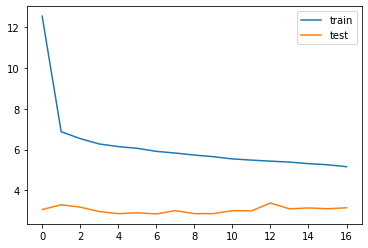

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

Model 2:

In [ ]:
model = Sequential()

model.add(layers.Bidirectional(layers.LSTM(units=128,return_sequences=True,input_shape=(X_train.shape[1], X_train.shape[2]))))

model.add(layers.LSTM(units= 128, return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(units= 128))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(units = 1))

model.compile(optimizer="adam", loss="mean_squared_error", metrics=["acc"])


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience = 15)

In [ ]:
batch_size = 124
epochs = 30

history = model.fit(
    X_train, y_train, 
    epochs=batch_size, 
    batch_size=epochs, 
    validation_data=(X_test, y_test),
    shuffle=False,
    callbacks = [early_stop]
)

Epoch 1/124
1380/1380 [==============================] - 25s 13ms/step - loss: 9.8158 - acc: 0.1343 - val_loss: 3.3573 - val_acc: 0.1999
Epoch 2/124
1380/1380 [==============================] - 17s 13ms/step - loss: 6.8637 - acc: 0.1494 - val_loss: 3.4469 - val_acc: 0.1983
Epoch 3/124
1380/1380 [==============================] - 17s 13ms/step - loss: 6.4835 - acc: 0.1572 - val_loss: 3.3548 - val_acc: 0.2149
Epoch 4/124
1380/1380 [==============================] - 18s 13ms/step - loss: 6.3618 - acc: 0.1593 - val_loss: 3.1000 - val_acc: 0.2162
Epoch 5/124
1380/1380 [==============================] - 17s 13ms/step - loss: 6.1413 - acc: 0.1608 - val_loss: 3.1320 - val_acc: 0.2185
Epoch 6/124
1380/1380 [==============================] - 17s 12ms/step - loss: 6.0802 - acc: 0.1617 - val_loss: 2.9661 - val_acc: 0.2112
Epoch 7/124
1380/1380 [==============================] - 17s 13ms/step - loss: 5.9275 - acc: 0.1598 - val_loss: 2.8891 - val_acc: 0.2159
Epoch 8/124
1380/1380 [==================

In [ ]:
from keras.metrics import accuracy
with mlflow.start_run():

    params = dict(batch_size=batch_size, epochs=epochs)
    metrics = dict(loss=min(history.history['loss']), accuracy=max(history.history['acc']))

    mlflow.log_params(params)
    mlflow.log_metrics(metrics)

    mlflow.keras.log_model(keras_model=model,
                           artifact_path="model",
                           keras_module="tensorflow.keras",
                           registered_model_name="bicimad_model2_ALLDATA_Bidirectional_LSTM128_LSTM128_Drop_LSTM128_Drop_Dense")

2022/08/31 17:59:06 WARNING mlflow.utils.requirements_utils: Found tensorflow version (2.8.2+zzzcolab20220719082949) contains a local version label (+zzzcolab20220719082949). MLflow logged a pip requirement for this package as 'tensorflow==2.8.2' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2022/08/31 17:59:20 WARNING mlflow.utils.requirements_utils: Found tensorflow version (2.8.2+zzzcolab20220719082949) contains a local version label (+zzzcolab20220719082949). MLflow logged a pip requirement for this package as 'tensorflow==2.8.2' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2022/08/31 17:59:20 WARNING mlflow.utils.requirements_utils: Found jaxlib version (0.3.14+cuda11.cudnn805) contains a local version label (+cuda11.cudnn805). ML

In [ ]:
## MODEL 3

In [ ]:
# importing libraries
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout

# initializing the RNN
regressor = Sequential()

# adding first RNN layer and dropout regulatization
regressor.add(SimpleRNN(units = 50, activation = "tanh", return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
regressor.add(Dropout(0.2))

# adding second RNN layer and dropout regulatization
regressor.add(SimpleRNN(units = 50, activation = "tanh",return_sequences = True))
regressor.add(Dropout(0.2))

# adding third RNN layer and dropout regulatization
regressor.add(SimpleRNN(units = 50,activation = "tanh", return_sequences = True))
regressor.add(Dropout(0.2))

# adding fourth RNN layer and dropout regulatization
regressor.add(SimpleRNN(units = 50))
regressor.add(Dropout(0.2))

# adding the output layer
regressor.add(Dense(units = 1))

# compiling RNN
regressor.compile(optimizer = "adam", loss = "mean_squared_error",metrics = ["accuracy"]) #rmspr


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience = 15)

In [ ]:
batch_size= 124
epochs=30
history = regressor.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), shuffle=False, callbacks = [early_stop])

Epoch 1/30
334/334 [==============================] - 33s 91ms/step - loss: 30.7136 - accuracy: 0.1181 - val_loss: 3.8490 - val_accuracy: 0.1844
Epoch 2/30
334/334 [==============================] - 30s 91ms/step - loss: 12.8714 - accuracy: 0.1262 - val_loss: 4.8852 - val_accuracy: 0.1838
Epoch 3/30
334/334 [==============================] - 31s 94ms/step - loss: 10.7582 - accuracy: 0.1218 - val_loss: 4.3635 - val_accuracy: 0.1830
Epoch 4/30
334/334 [==============================] - 29s 88ms/step - loss: 10.0002 - accuracy: 0.1223 - val_loss: 6.4167 - val_accuracy: 0.1814
Epoch 5/30
334/334 [==============================] - 30s 89ms/step - loss: 9.6522 - accuracy: 0.1227 - val_loss: 4.9744 - val_accuracy: 0.1813
Epoch 6/30
334/334 [==============================] - 30s 89ms/step - loss: 9.4622 - accuracy: 0.1245 - val_loss: 3.3950 - val_accuracy: 0.1761
Epoch 7/30
334/334 [==============================] - 32s 96ms/step - loss: 9.3466 - accuracy: 0.1213 - val_loss: 3.4262 - val_accur

KeyboardInterrupt: ignored

In [ ]:
with mlflow.start_run():

    params = dict(batch_size=batch_size, epochs=epochs)
    metrics = dict(loss=min(history.history['loss']), accuracy=max(history.history['accuracy']))

    mlflow.log_params(params)
    mlflow.log_metrics(metrics)

    mlflow.keras.log_model(keras_model=regressor,
                           artifact_path="model",
                           keras_module="tensorflow.keras",
                           registered_model_name="bicimad_model3_Thierry_SimpleRNN50_Drop_SimpleRNN50_Drop_SimpleRNN50_Drop_tanh.all_SimpleRNN50_Drop_Dense")

2022/08/31 15:06:30 WARNING mlflow.utils.requirements_utils: Found tensorflow version (2.8.2+zzzcolab20220719082949) contains a local version label (+zzzcolab20220719082949). MLflow logged a pip requirement for this package as 'tensorflow==2.8.2' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2022/08/31 15:06:36 WARNING mlflow.utils.requirements_utils: Found tensorflow version (2.8.2+zzzcolab20220719082949) contains a local version label (+zzzcolab20220719082949). MLflow logged a pip requirement for this package as 'tensorflow==2.8.2' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2022/08/31 15:06:36 WARNING mlflow.utils.requirements_utils: Found jaxlib version (0.3.14+cuda11.cudnn805) contains a local version label (+cuda11.cudnn805). ML

In [ ]:
### MODEL 4

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.optimizers import RMSprop


def create_model(X_train, y_train):
    
    
    print(X_train.shape)
    print(y_train.shape)
    
    #tf.random.set_seed(30)
    normalizer = Normalization() # Instantiate a "normalizer" layer
    normalizer.adapt(X_train) # "Fit" it on the train set
    model = Sequential()
    model.add(normalizer)
    model.add(layers.LSTM(25, return_sequences=False, input_shape=(X_train.shape[1],X_train.shape[2])))

    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(15, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(y_train.shape[-1], activation='linear'))
    model.compile(loss='mse',optimizer=RMSprop(learning_rate=0.01), metrics=['mae', 'mape'])
    print(model.summary())
    print(X_train.shape)

    return model


In [ ]:
model = create_model(X_train, y_train)

(41397, 24, 52)
(41397,)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, None, 52)         105       
 n)                                                              
                                                                 
 lstm_4 (LSTM)               (None, 25)                7800      
                                                                 
 dropout_7 (Dropout)         (None, 25)                0         
                                                                 
 dense_3 (Dense)             (None, 15)                390       
                                                                 
 dropout_8 (Dropout)         (None, 15)                0         
                                                                 
 dense_4 (Dense)             (None, 41397)             662352    
                             

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience = 10)

In [ ]:
batch_size = 100
epochs = 20

history = model.fit(
    X_train, y_train, 
    epochs=epochs, 
    batch_size=batch_size, 
    validation_data=(X_test, y_test),
    shuffle=False,
    callbacks = [early_stop]
)

Epoch 1/20
414/414 [==============================] - 6s 10ms/step - loss: 15.3948 - mae: 2.7868 - mape: 268126048.0000 - val_loss: 3.6146 - val_mae: 1.3889 - val_mape: 189569392.0000
Epoch 2/20
414/414 [==============================] - 3s 8ms/step - loss: 10.5636 - mae: 2.3375 - mape: 246379840.0000 - val_loss: 3.3753 - val_mae: 1.3365 - val_mape: 186625520.0000
Epoch 3/20
414/414 [==============================] - 3s 8ms/step - loss: 9.7731 - mae: 2.2908 - mape: 266324480.0000 - val_loss: 3.4864 - val_mae: 1.3911 - val_mape: 212873696.0000
Epoch 4/20
414/414 [==============================] - 4s 10ms/step - loss: 9.6048 - mae: 2.2758 - mape: 275603008.0000 - val_loss: 3.4626 - val_mae: 1.3942 - val_mape: 222267440.0000
Epoch 5/20
414/414 [==============================] - 4s 9ms/step - loss: 9.3519 - mae: 2.2458 - mape: 272484960.0000 - val_loss: 3.4802 - val_mae: 1.3936 - val_mape: 221189376.0000
Epoch 6/20
414/414 [==============================] - 4s 9ms/step - loss: 9.2488 - mae

In [ ]:
with mlflow.start_run():

    params = dict(batch_size=batch_size, epochs=epochs)
    metrics = dict(loss=min(history.history['loss']), accuracy=min(history.history['mae']))

    mlflow.log_params(params)
    mlflow.log_metrics(metrics)

    mlflow.keras.log_model(keras_model=model,
                           artifact_path="model",
                           keras_module="tensorflow.keras",
                           registered_model_name="bicimad_model4_Thierry_LSTM25_Drop_Dense15_Drop_Dense")

2022/08/31 15:15:39 WARNING mlflow.utils.requirements_utils: Found tensorflow version (2.8.2+zzzcolab20220719082949) contains a local version label (+zzzcolab20220719082949). MLflow logged a pip requirement for this package as 'tensorflow==2.8.2' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2022/08/31 15:15:44 WARNING mlflow.utils.requirements_utils: Found tensorflow version (2.8.2+zzzcolab20220719082949) contains a local version label (+zzzcolab20220719082949). MLflow logged a pip requirement for this package as 'tensorflow==2.8.2' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2022/08/31 15:15:44 WARNING mlflow.utils.requirements_utils: Found jaxlib version (0.3.14+cuda11.cudnn805) contains a local version label (+cuda11.cudnn805). ML

Model 5

In [ ]:
model = Sequential()
model.add(
    layers.Bidirectional(
    layers.LSTM(
      units=75,
      input_shape=(X_train.shape[1], X_train.shape[2]),
    ), 
  )
)
model.add(layers.Dropout(rate=0.2))
model.add(layers.Dense(units=1))

model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor="val_loss", verbose=1, patience = 10)

In [ ]:
batch_size = 124
epochs = 35

history = model.fit(
    X_train, y_train, 
    epochs=epochs, 
    batch_size=batch_size, 
    validation_data=(X_test, y_test),
    shuffle=False,
    callbacks = [early_stop]
)

Epoch 1/35
334/334 [==============================] - 31s 11ms/step - loss: 21.7559 - val_loss: 4.1245
Epoch 2/35
334/334 [==============================] - 3s 9ms/step - loss: 7.8488 - val_loss: 5.2139
Epoch 3/35
334/334 [==============================] - 3s 9ms/step - loss: 7.2521 - val_loss: 4.1773
Epoch 4/35
334/334 [==============================] - 3s 9ms/step - loss: 6.8220 - val_loss: 3.8563
Epoch 5/35
334/334 [==============================] - 3s 9ms/step - loss: 6.5783 - val_loss: 3.1690
Epoch 6/35
334/334 [==============================] - 3s 9ms/step - loss: 6.5566 - val_loss: 4.0877
Epoch 7/35
334/334 [==============================] - 3s 9ms/step - loss: 6.3657 - val_loss: 2.7335
Epoch 8/35
334/334 [==============================] - 3s 9ms/step - loss: 6.2056 - val_loss: 3.0586
Epoch 9/35
334/334 [==============================] - 3s 9ms/step - loss: 6.1318 - val_loss: 2.9861
Epoch 10/35
334/334 [==============================] - 3s 9ms/step - loss: 6.0594 - val_loss: 3.0

In [ ]:
with mlflow.start_run():

    params = dict(batch_size=batch_size, epochs=epochs)
    metrics = dict(loss=min(history.history['loss']))

    mlflow.log_params(params)
    mlflow.log_metrics(metrics)

    mlflow.keras.log_model(keras_model=model,
                           artifact_path="model",
                           keras_module="tensorflow.keras",
                           registered_model_name="bicimad_model5_Bidirectional_LSTM75_Drop_Dense")

2022/08/31 15:53:15 WARNING mlflow.utils.requirements_utils: Found tensorflow version (2.8.2+zzzcolab20220719082949) contains a local version label (+zzzcolab20220719082949). MLflow logged a pip requirement for this package as 'tensorflow==2.8.2' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2022/08/31 15:53:25 WARNING mlflow.utils.requirements_utils: Found tensorflow version (2.8.2+zzzcolab20220719082949) contains a local version label (+zzzcolab20220719082949). MLflow logged a pip requirement for this package as 'tensorflow==2.8.2' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2022/08/31 15:53:25 WARNING mlflow.utils.requirements_utils: Found jaxlib version (0.3.14+cuda11.cudnn805) contains a local version label (+cuda11.cudnn805). ML

In [ ]:
## MODEL 6

In [ ]:
model = Sequential()
model.add(
    layers.Bidirectional(
    layers.LSTM(
      units=50,
      input_shape=(X_train.shape[1], X_train.shape[2]),
    ), 
  )
)
model.add(layers.Dropout(rate=0.2))
model.add(layers.Dense(units=1))

model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor="val_loss", verbose=1, patience = 10)

In [ ]:
batch_size = 64
epochs = 35

history = model.fit(
    X_train, y_train, 
    epochs=epochs, 
    batch_size=batch_size, 
    validation_data=(X_test, y_test),
    shuffle=False,
    callbacks = [early_stop]
)

Epoch 1/35
323/323 [==============================] - 9s 19ms/step - loss: 27.7078 - val_loss: 13.9503
Epoch 2/35
323/323 [==============================] - 8s 23ms/step - loss: 10.0961 - val_loss: 8.6504
Epoch 3/35
323/323 [==============================] - 6s 17ms/step - loss: 8.6099 - val_loss: 6.5694
Epoch 4/35
323/323 [==============================] - 5s 17ms/step - loss: 8.3423 - val_loss: 5.7810
Epoch 5/35
323/323 [==============================] - 6s 20ms/step - loss: 8.0289 - val_loss: 5.6022
Epoch 6/35
323/323 [==============================] - 6s 18ms/step - loss: 7.9329 - val_loss: 5.5850
Epoch 7/35
323/323 [==============================] - 5s 16ms/step - loss: 7.8637 - val_loss: 5.4663
Epoch 8/35
323/323 [==============================] - 5s 16ms/step - loss: 7.6484 - val_loss: 5.4769
Epoch 9/35
323/323 [==============================] - 5s 17ms/step - loss: 7.5537 - val_loss: 5.3467
Epoch 10/35
323/323 [==============================] - 5s 17ms/step - loss: 7.4938 - val

In [ ]:
with mlflow.start_run():

    params = dict(batch_size=batch_size, epochs=epochs)
    metrics = dict(loss=min(history.history['loss']))

    mlflow.log_params(params)
    mlflow.log_metrics(metrics)

    mlflow.keras.log_model(keras_model=model,
                           artifact_path="model",
                           keras_module="tensorflow.keras",
                           registered_model_name="bicimad_model6_Bidirectional_LSTM50_Drop_Dense")

2022/08/31 15:57:10 WARNING mlflow.utils.requirements_utils: Found tensorflow version (2.8.2+zzzcolab20220719082949) contains a local version label (+zzzcolab20220719082949). MLflow logged a pip requirement for this package as 'tensorflow==2.8.2' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2022/08/31 15:57:18 WARNING mlflow.utils.requirements_utils: Found tensorflow version (2.8.2+zzzcolab20220719082949) contains a local version label (+zzzcolab20220719082949). MLflow logged a pip requirement for this package as 'tensorflow==2.8.2' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2022/08/31 15:57:18 WARNING mlflow.utils.requirements_utils: Found jaxlib version (0.3.14+cuda11.cudnn805) contains a local version label (+cuda11.cudnn805). ML

In [ ]:
### MODEL 7

In [ ]:
model = Sequential()

model.add(layers.Bidirectional(layers.LSTM(units=100,return_sequences=True,input_shape=(X_train.shape[1], X_train.shape[2]))))

model.add(layers.LSTM(units= 100, return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(units= 75))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(units = 1))

model.compile(optimizer="adam", loss="mean_squared_error", metrics=["acc"])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience = 10)

In [ ]:
batch_size = 64
epochs = 30

history = model.fit(
    X_train, y_train, 
    epochs=batch_size, 
    batch_size=epochs, 
    validation_data=(X_test, y_test),
    shuffle=False,
    callbacks = [early_stop]
)

Epoch 1/64
689/689 [==============================] - 50s 64ms/step - loss: 15.6916 - acc: 0.1388 - val_loss: 8.3173 - val_acc: 0.0157
Epoch 2/64
689/689 [==============================] - 36s 52ms/step - loss: 8.7827 - acc: 0.1452 - val_loss: 6.1036 - val_acc: 0.0157
Epoch 3/64
689/689 [==============================] - 36s 52ms/step - loss: 8.2082 - acc: 0.1618 - val_loss: 5.4982 - val_acc: 0.0157
Epoch 4/64
689/689 [==============================] - 37s 54ms/step - loss: 8.0589 - acc: 0.1641 - val_loss: 5.4008 - val_acc: 0.0157
Epoch 5/64
689/689 [==============================] - 36s 52ms/step - loss: 7.9290 - acc: 0.1648 - val_loss: 5.5827 - val_acc: 0.0157
Epoch 6/64
689/689 [==============================] - 38s 55ms/step - loss: 7.8548 - acc: 0.1660 - val_loss: 5.5120 - val_acc: 0.0157
Epoch 7/64
689/689 [==============================] - 35s 51ms/step - loss: 7.7282 - acc: 0.1669 - val_loss: 5.7141 - val_acc: 0.0157
Epoch 8/64
689/689 [==============================] - 36s 52m

In [ ]:
from keras.metrics import accuracy
with mlflow.start_run():

    params = dict(batch_size=batch_size, epochs=epochs)
    metrics = dict(loss=min(history.history['loss']), accuracy=max(history.history['acc']))

    mlflow.log_params(params)
    mlflow.log_metrics(metrics)

    mlflow.keras.log_model(keras_model=model,
                           artifact_path="model",
                           keras_module="tensorflow.keras",
                           registered_model_name="bicimad_model7_Bidirectional_LSTM100_LSTM100_Drop_LSTM75_Drop_Dense")

2022/08/31 16:09:21 WARNING mlflow.utils.requirements_utils: Found tensorflow version (2.8.2+zzzcolab20220719082949) contains a local version label (+zzzcolab20220719082949). MLflow logged a pip requirement for this package as 'tensorflow==2.8.2' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2022/08/31 16:09:34 WARNING mlflow.utils.requirements_utils: Found tensorflow version (2.8.2+zzzcolab20220719082949) contains a local version label (+zzzcolab20220719082949). MLflow logged a pip requirement for this package as 'tensorflow==2.8.2' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2022/08/31 16:09:34 WARNING mlflow.utils.requirements_utils: Found jaxlib version (0.3.14+cuda11.cudnn805) contains a local version label (+cuda11.cudnn805). ML

In [ ]:
y_pred = model.predict(X_test)

4/4 [==============================] - 5s 54ms/step


(array([  0.,   0.,   0.,   0.,   0., 127.,   0.,   0.,   0.,   0.]),
 array([ 9.688438,  9.788439,  9.888438,  9.988439, 10.088438, 10.188438,
        10.288439, 10.388438, 10.488439, 10.588438, 10.688438],
       dtype=float32),
 <BarContainer object of 10 artists>)

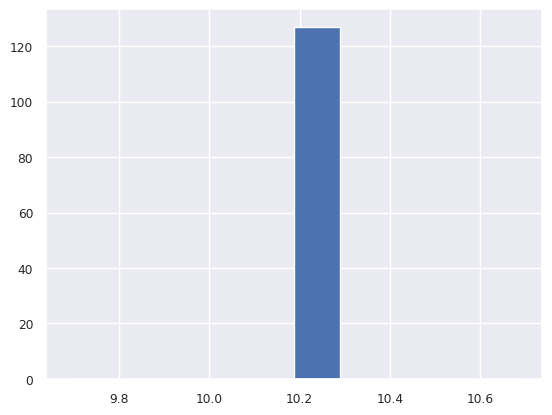

In [ ]:
plt.hist(y_pred)